# Importação de bibliotecas

In [1]:
from ucimlrepo import fetch_ucirepo
from typing import Tuple, List
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

# Definição de constantes

In [2]:
np.random.seed(42)
K_NUMBER = 9
TARGET_COLUMN_NAME = "class"
TEST_SIZE = 0.2
HOLDOUT_INDEXES_NUMBER = 20
FIG_SIZE = (12, 8)

# Baixando dataset iris

In [3]:
iris = fetch_ucirepo(id=53)

X_iris = iris.data.features
y_iris = iris.data.targets

iris_df = pd.concat([X_iris, y_iris], axis="columns")

# Verificando número de classes

In [4]:
iris_df[TARGET_COLUMN_NAME].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

# Redefinindo classes para valores numéricos

In [5]:
class_mapping = {"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}
iris_df[TARGET_COLUMN_NAME] = iris_df[TARGET_COLUMN_NAME].map(class_mapping)
iris_df[TARGET_COLUMN_NAME]

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: class, Length: 150, dtype: int64

# Funções diversas

In [6]:
def calculate_accuracy(y_true: np.array, y_pred: np.array) -> float:
    return np.sum(y_true == y_pred) / len(y_true)


def calculate_error_rate(y_true: np.array, y_pred: np.array) -> float:
    return 1 - calculate_accuracy(y_true, y_pred)


def confusion_matrix(y_true: np.array, y_pred: np.array) -> np.array:
    unique_classes = np.unique(np.concatenate((y_true, y_pred)))
    num_classes = len(unique_classes)
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for true_label, pred_label in zip(y_true, y_pred):
        conf_matrix[true_label, pred_label] += 1

    return conf_matrix


def create_holdout_indexes(df: pd.DataFrame, test_size: float) -> Tuple[list, list]:
    df_len = len(df)
    test_size = int(df_len * test_size)
    train_size = df_len - test_size
    indexes = list(df.index)
    train_indexes = np.random.choice(indexes, train_size, replace=False)
    test_indexes = tuple(set(indexes) - set(train_indexes))
    return list(train_indexes), list(test_indexes)


def create_multiple_holdout_indexes(
    df: pd.DataFrame, n_indexes: int, test_size: float
) -> List[Tuple[np.array, np.array]]:
    indexes_list = []
    for _ in range(n_indexes):
        indexes_list.append(create_holdout_indexes(df, test_size))
    return indexes_list


def separate_train_test(
    df: pd.DataFrame, train_indexes: list, test_indexes: list, target_column_name: str
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    train_df = df.loc[train_indexes]
    test_df = df.loc[test_indexes]

    X_train = train_df.drop(target_column_name, axis="columns")
    y_train = train_df[target_column_name]
    X_test = test_df.drop(target_column_name, axis="columns")
    y_test = test_df[target_column_name]

    return X_train, y_train, X_test, y_test


def calculate_euclidean_distance(x1: np.array, x2: np.array) -> float:
    return np.sqrt(np.sum((x1 - x2) ** 2))


def calculate_distances(
    X_train: pd.Series, test_sample: pd.Series, distance_calculator_function: callable
) -> List[np.array]:
    distances = []
    for index, train_sample in X_train.iterrows():
        distance = distance_calculator_function(train_sample, test_sample)
        distances.append([index, distance])

    return distances


def knn_predict(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    k: int,
    distance_calculator_function: callable,
) -> np.array:
    y_pred = []
    for index, test_sample in X_test.iterrows():
        distances = calculate_distances(
            X_train, test_sample, distance_calculator_function
        )
        distances.sort(key=lambda x: x[1])
        k_nearest_indexes = [index for index, _ in distances[:k]]
        k_nearest_classes = y_train.loc[k_nearest_indexes]
        mode_class = k_nearest_classes.mode()[0]
        y_pred.append(mode_class)

    return np.array(y_pred)


def calculete_centroids(X_train: pd.DataFrame, y_train: pd.Series) -> pd.DataFrame:
    classes = y_train.unique()
    centroids = {}
    for cls in classes:
        class_samples = X_train[y_train == cls]
        centroids[cls] = class_samples.mean()

    return pd.DataFrame(centroids)


def nearest_centroid_predict(
    X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame
) -> np.array:
    centroids = calculete_centroids(X_train, y_train)
    y_pred = []
    for index, test_sample in X_test.iterrows():
        distances = []
        for cls, centroid in centroids.items():
            distance = calculate_euclidean_distance(centroid, test_sample)
            distances.append([cls, distance])
        distances.sort(key=lambda x: x[1])
        y_pred.append(distances[0][0])

    return np.array(y_pred)

# Treinamento e avaliação dos modelos, juntamente com a criação de tabela de métricas para o KNN(k-vizinhos mais próximos)

In [7]:
knn_holdout_indexes = create_multiple_holdout_indexes(
    df=iris_df, n_indexes=HOLDOUT_INDEXES_NUMBER, test_size=TEST_SIZE
)

knn_accuracy_list = []

for train_indexes, test_indexes in knn_holdout_indexes:
    X_train, y_train, X_test, y_test = separate_train_test(
        df=iris_df,
        train_indexes=train_indexes,
        test_indexes=test_indexes,
        target_column_name=TARGET_COLUMN_NAME,
    )
    y_pred = knn_predict(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        k=K_NUMBER,
        distance_calculator_function=calculate_euclidean_distance,
    )

    accuracy = calculate_accuracy(y_true=y_test, y_pred=y_pred)
    error_rate = calculate_error_rate(y_true=y_test, y_pred=y_pred)

    confusion_matrix_result = confusion_matrix(y_true=y_test, y_pred=y_pred)

    knn_accuracy_list.append(
        (
            accuracy,
            error_rate,
            train_indexes,
            test_indexes,
            y_pred,
            confusion_matrix_result,
        )
    )

df_results_knn = pd.DataFrame(
    knn_accuracy_list,
    columns=[
        "accuracy",
        "error_rate",
        "train_indexes",
        "test_indexes",
        "y_pred",
        "confusion_matrix",
    ],
)

df_results_knn

,accuracy,error_rate,train_indexes,test_indexes,y_pred,confusion_matrix
0,0.966667,0.033333,"[73, 18, 118, 78, 76, 31, 64, 141, 68, 82, 110...","[1, 129, 130, 140, 14, 144, 20, 21, 149, 37, 4...","[0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 1, 1, ...","[[7, 0, 0], [0, 11, 0], [0, 1, 11]]"
1,0.933333,0.066667,"[84, 20, 45, 47, 149, 114, 144, 117, 9, 90, 14...","[128, 129, 2, 133, 138, 12, 140, 142, 143, 26,...","[2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, ...","[[9, 0, 0], [0, 6, 2], [0, 0, 13]]"
2,0.933333,0.066667,"[54, 71, 117, 30, 58, 81, 10, 64, 51, 28, 131,...","[129, 133, 134, 7, 135, 141, 145, 18, 146, 20,...","[2, 1, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, ...","[[10, 0, 0], [0, 5, 0], [0, 2, 13]]"
3,1.000000,0.000000,"[51, 101, 131, 129, 106, 121, 141, 105, 37, 12...","[0, 1, 3, 135, 9, 140, 15, 143, 146, 149, 22, ...","[0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, ...","[[13, 0, 0], [0, 9, 0], [0, 0, 8]]"
4,0.966667,0.033333,"[120, 110, 123, 94, 6, 129, 76, 51, 82, 47, 13...","[0, 131, 5, 134, 136, 142, 144, 18, 24, 32, 35...","[0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[10, 0, 0], [0, 8, 1], [0, 0, 11]]"
5,1.000000,0.000000,"[85, 30, 108, 125, 10, 123, 95, 144, 82, 104, ...","[2, 130, 131, 132, 135, 11, 146, 29, 37, 46, 4...","[0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, ...","[[6, 0, 0], [0, 12, 0], [0, 0, 12]]"
6,0.966667,0.033333,"[15, 99, 57, 133, 87, 41, 75, 47, 81, 97, 113,...","[129, 130, 3, 5, 138, 139, 140, 20, 25, 30, 32...","[2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, ...","[[8, 0, 0], [0, 11, 1], [0, 0, 10]]"
7,1.000000,0.000000,"[143, 138, 95, 100, 58, 3, 104, 93, 107, 120, ...","[129, 4, 136, 9, 14, 142, 147, 148, 149, 25, 2...","[2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, ...","[[10, 0, 0], [0, 8, 0], [0, 0, 12]]"
8,0.966667,0.033333,"[51, 12, 144, 118, 85, 74, 140, 48, 149, 78, 1...","[130, 134, 7, 135, 9, 138, 141, 147, 31, 33, 3...","[2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, ...","[[6, 0, 0], [0, 13, 1], [0, 0, 10]]"
9,1.000000,0.000000,"[93, 27, 124, 126, 52, 21, 37, 117, 119, 5, 13...","[128, 130, 133, 11, 16, 145, 18, 24, 34, 38, 3...","[2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[11, 0, 0], [0, 9, 0], [0, 0, 10]]"


# Vetor de acurácias

In [8]:
knn_accuracy_vector = pd.Series(df_results_knn["accuracy"])
knn_accuracy_vector

0     0.966667
1     0.933333
2     0.933333
3     1.000000
4     0.966667
5     1.000000
6     0.966667
7     1.000000
8     0.966667
9     1.000000
10    0.966667
11    0.966667
12    0.966667
13    0.933333
14    0.933333
15    0.966667
16    0.966667
17    0.900000
18    0.966667
19    0.933333
Name: accuracy, dtype: float64

# Boxplot das acurácias do KNN

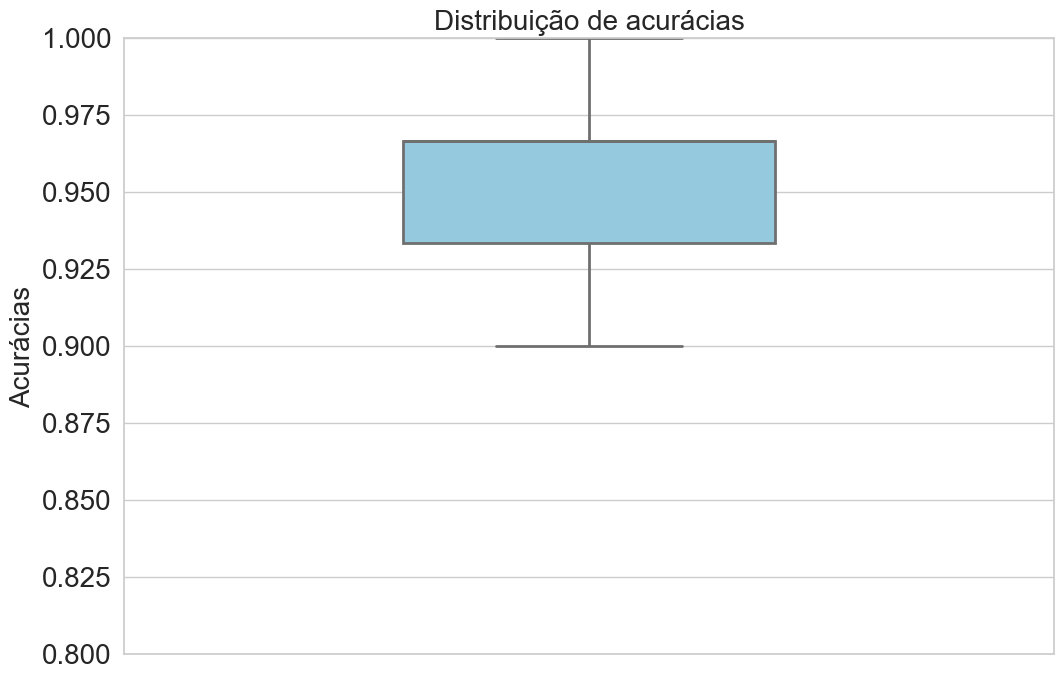

In [9]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=FIG_SIZE)
sns.boxplot(y=knn_accuracy_vector, width=0.4, color="skyblue", linewidth=2, fliersize=5)
plt.title("Distribuição de acurácias", fontsize=20)
plt.ylabel("Acurácias", fontsize=20)
plt.ylim(min(knn_accuracy_vector) - 0.1, 1)
plt.yticks(fontsize=20)
plt.show()

# Baseado na melhor acurácia, pego os indices de treino e teste que geraram ela e calculo a superfície de decisão e também resgato a sua respectiva matriz de confusão

In [10]:
max_accuracy = df_results_knn["accuracy"].max()
indexes_of_max_accuracy = df_results_knn[
    df_results_knn["accuracy"] == max_accuracy
].index.tolist()

index_selected = random.choice(indexes_of_max_accuracy)

print("Índices da melhor acurácia:", indexes_of_max_accuracy)
print("Índice selecionado:", index_selected)
print("Acurácia:", max_accuracy)

best_accuracy_train_indexes = df_results_knn.loc[index_selected, "train_indexes"]
best_accuracy_test_indexes = df_results_knn.loc[index_selected, "test_indexes"]

X_train, y_train, X_test, y_test = separate_train_test(
    df=iris_df,
    train_indexes=best_accuracy_train_indexes,
    test_indexes=best_accuracy_test_indexes,
    target_column_name=TARGET_COLUMN_NAME,
)

Índices da melhor acurácia: [3, 5, 7, 9]
Índice selecionado: 3
Acurácia: 1.0


# Resgatando a matriz de confusão e plotando ela

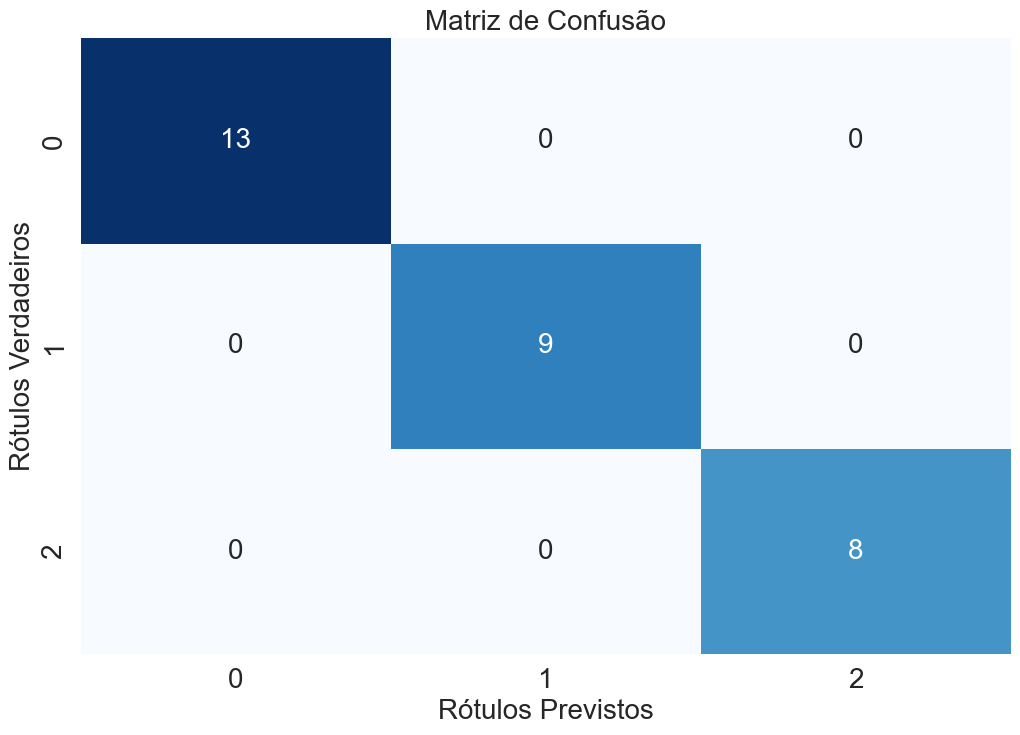

In [11]:
confusion_matrix_result = df_results_knn.loc[index_selected, "confusion_matrix"]

plt.figure(figsize=FIG_SIZE)
sns.heatmap(
    confusion_matrix_result,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    annot_kws={"size": 20},
)
plt.xlabel("Rótulos Previstos", fontsize=20)
plt.ylabel("Rótulos Verdadeiros", fontsize=20)
plt.title("Matriz de Confusão", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Calculo de superfície de decisão para o KNN

In [12]:
feature_x = X_train.columns[0]
feature_y = X_train.columns[1]

feature_x_max = X_train[feature_x].max()
feature_x_min = X_train[feature_x].min()

feature_y_max = X_train[feature_y].max()
feature_y_min = X_train[feature_y].min()

print(f"Feature {feature_x} - Máximo: {feature_x_max}, Mínimo: {feature_x_min}")
print(f"Feature {feature_y} - Máximo: {feature_y_max}, Mínimo: {feature_y_min}")

h = 0.05

xx, yy = np.meshgrid(
    np.arange(feature_x_min, feature_x_max + h, h),
    np.arange(feature_y_min, feature_y_max + h, h),
)

test_grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[feature_x, feature_y])

Z = knn_predict(
    X_train,
    y_train,
    test_grid,
    k=K_NUMBER,
    distance_calculator_function=calculate_euclidean_distance,
)

Z = Z.reshape(xx.shape)

Feature sepal length - Máximo: 7.9, Mínimo: 4.3
Feature sepal width - Máximo: 4.0, Mínimo: 2.0


# Plot da superfície de decisão para o KNN

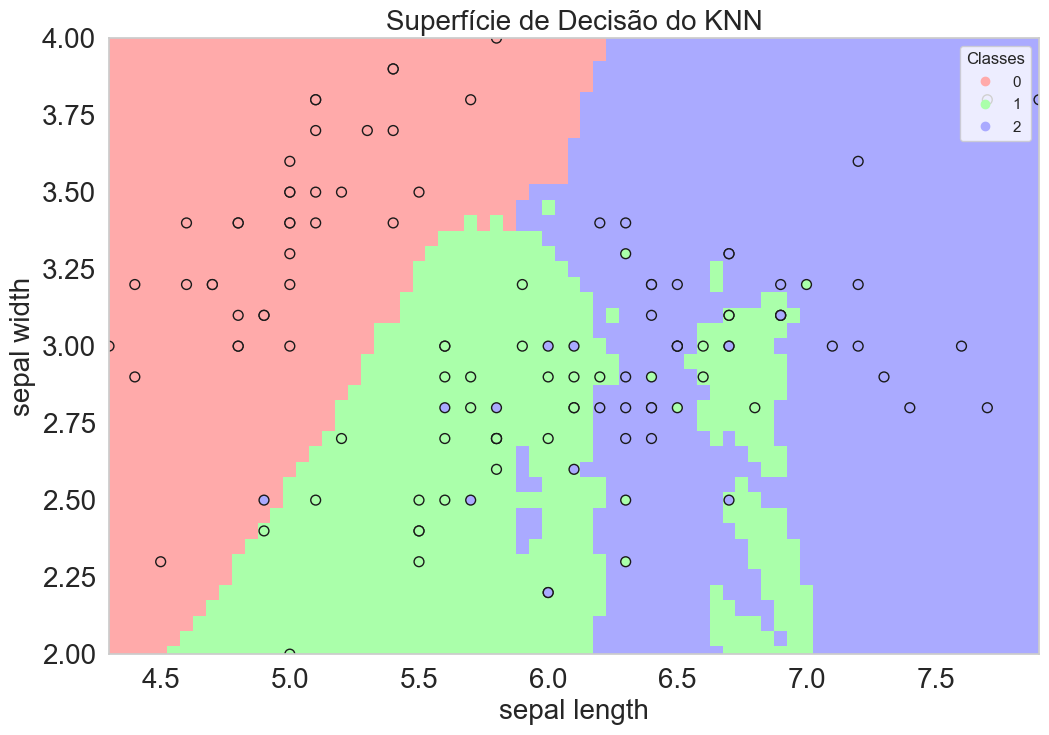

In [13]:
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])

plt.figure(figsize=FIG_SIZE)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
sc = plt.scatter(
    X_train[feature_x],
    X_train[feature_y],
    c=y_train,
    edgecolor="k",
    s=50,
    cmap=cmap_light,
)
plt.legend(*sc.legend_elements(), title="Classes", loc="upper right")

plt.xlabel(feature_x, fontsize=20)
plt.ylabel(feature_y, fontsize=20)
plt.title("Superfície de Decisão do KNN", fontsize=20)

plt.xlim(feature_x_min, feature_x_max)
plt.ylim(feature_y_min, feature_y_max)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Treinamento e avaliação dos modelos, juntamente com a criação de tabela de métricas para o NC(centróide mais próximo)

In [14]:
ncp_holdout_indexes = create_multiple_holdout_indexes(
    df=iris_df, n_indexes=HOLDOUT_INDEXES_NUMBER, test_size=TEST_SIZE
)

ncp_accuracy_list = []

for train_indexes, test_indexes in ncp_holdout_indexes:
    X_train, y_train, X_test, y_test = separate_train_test(
        df=iris_df,
        train_indexes=train_indexes,
        test_indexes=test_indexes,
        target_column_name=TARGET_COLUMN_NAME,
    )
    y_pred = nearest_centroid_predict(X_train=X_train, y_train=y_train, X_test=X_test)

    accuracy = calculate_accuracy(y_true=y_test, y_pred=y_pred)
    error_rate = calculate_error_rate(y_true=y_test, y_pred=y_pred)

    confusion_matrix_result = confusion_matrix(y_true=y_test, y_pred=y_pred)

    ncp_accuracy_list.append(
        (
            accuracy,
            error_rate,
            train_indexes,
            test_indexes,
            y_pred,
            confusion_matrix_result,
        )
    )

df_results_nc = pd.DataFrame(
    ncp_accuracy_list,
    columns=[
        "accuracy",
        "error_rate",
        "train_indexes",
        "test_indexes",
        "y_pred",
        "confusion_matrix",
    ],
)

df_results_nc

,accuracy,error_rate,train_indexes,test_indexes,y_pred,confusion_matrix
0,0.833333,0.166667,"[11, 9, 141, 4, 79, 17, 28, 145, 31, 131, 98, ...","[130, 3, 132, 133, 8, 138, 142, 143, 146, 20, ...","[2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, ...","[[8, 0, 0], [0, 7, 0], [0, 5, 10]]"
1,0.933333,0.066667,"[31, 143, 93, 124, 101, 69, 9, 6, 15, 79, 83, ...","[128, 3, 7, 136, 137, 14, 146, 19, 20, 148, 25...","[2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, ...","[[12, 0, 0], [0, 8, 2], [0, 0, 8]]"
2,0.933333,0.066667,"[114, 58, 13, 143, 57, 147, 68, 90, 75, 81, 45...","[1, 2, 130, 9, 137, 11, 141, 149, 27, 38, 39, ...","[0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 1, ...","[[9, 0, 0], [0, 11, 2], [0, 0, 8]]"
3,0.933333,0.066667,"[129, 48, 13, 143, 89, 68, 75, 119, 101, 39, 1...","[128, 4, 132, 7, 136, 138, 16, 18, 20, 149, 23...","[2, 0, 2, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, ...","[[9, 0, 0], [0, 8, 0], [0, 2, 11]]"
4,0.933333,0.066667,"[57, 39, 133, 145, 100, 72, 92, 140, 93, 1, 2,...","[129, 135, 136, 139, 12, 15, 16, 144, 18, 146,...","[2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, ...","[[9, 0, 0], [0, 5, 1], [0, 1, 14]]"
5,0.900000,0.100000,"[124, 112, 0, 68, 18, 147, 95, 102, 29, 87, 62...","[129, 2, 132, 6, 7, 136, 12, 140, 141, 15, 142...","[2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 1, 0, 2, 0, 2, ...","[[11, 0, 0], [0, 8, 0], [0, 3, 8]]"
6,0.866667,0.133333,"[11, 30, 90, 118, 147, 71, 143, 72, 48, 138, 1...","[2, 4, 5, 133, 7, 134, 12, 14, 20, 149, 25, 37...","[0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, ...","[[11, 0, 0], [0, 10, 1], [0, 3, 5]]"
7,0.900000,0.100000,"[17, 11, 144, 34, 85, 19, 71, 81, 4, 129, 65, ...","[130, 131, 132, 138, 14, 142, 149, 22, 25, 27,...","[2, 2, 2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, ...","[[8, 0, 0], [0, 6, 1], [0, 2, 13]]"
8,0.933333,0.066667,"[102, 70, 119, 3, 78, 137, 145, 0, 29, 20, 92,...","[131, 132, 5, 12, 13, 14, 141, 18, 26, 31, 32,...","[2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, ...","[[9, 0, 0], [0, 11, 1], [0, 1, 8]]"
9,0.966667,0.033333,"[80, 130, 79, 107, 65, 139, 30, 123, 115, 55, ...","[128, 1, 5, 6, 9, 142, 147, 21, 24, 27, 31, 37...","[2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[13, 0, 0], [0, 8, 1], [0, 0, 8]]"


# Vetor de acurácias

In [15]:
nc_accuracy_vector = pd.Series(df_results_nc["accuracy"])
nc_accuracy_vector

0     0.833333
1     0.933333
2     0.933333
3     0.933333
4     0.933333
5     0.900000
6     0.866667
7     0.900000
8     0.933333
9     0.966667
10    0.966667
11    0.966667
12    0.900000
13    0.966667
14    0.900000
15    0.966667
16    0.933333
17    0.933333
18    0.933333
19    1.000000
Name: accuracy, dtype: float64

# Boxplot das acurácias para o NC

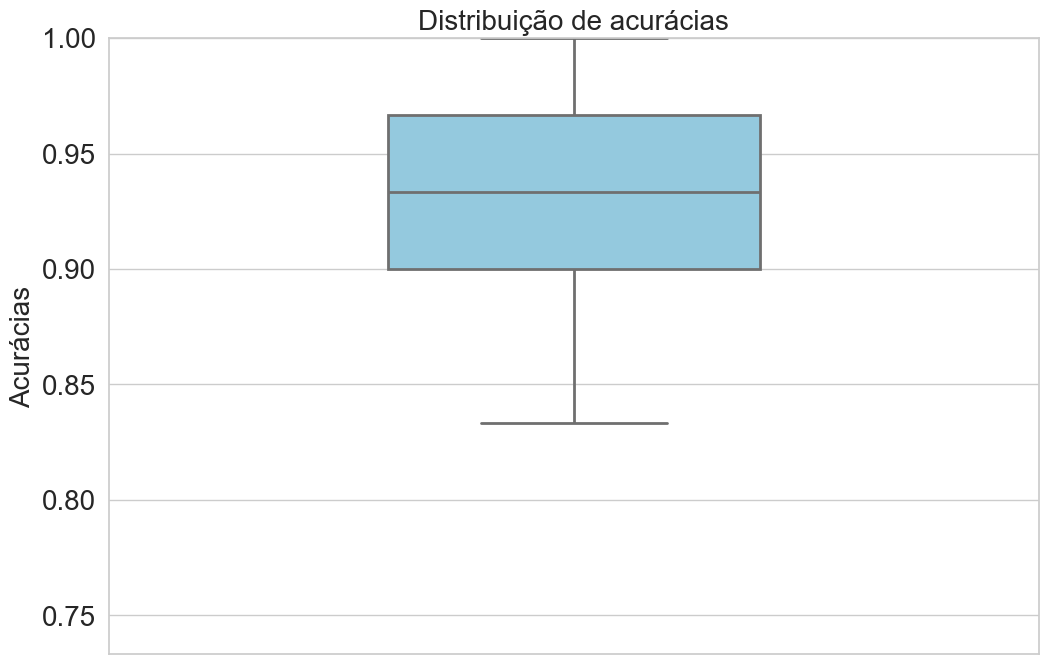

In [16]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=FIG_SIZE)
sns.boxplot(y=nc_accuracy_vector, width=0.4, color="skyblue", linewidth=2, fliersize=5)
plt.title("Distribuição de acurácias", fontsize=20)
plt.ylabel("Acurácias", fontsize=20)
plt.ylim(min(nc_accuracy_vector) - 0.1, 1)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Baseado na melhor acurácia, pego os indices de treino e teste que geraram ela e calculo a superfície de decisão e também resgato a sua respectiva matriz de confusão

In [17]:
max_accuracy = df_results_nc["accuracy"].max()
indexes_of_max_accuracy = df_results_nc[
    df_results_nc["accuracy"] == max_accuracy
].index.tolist()

index_selected = random.choice(indexes_of_max_accuracy)

print("Índices da melhor acurácia:", indexes_of_max_accuracy)
print("Índice selecionado:", index_selected)
print("Acurácia:", max_accuracy)

best_accuracy_train_indexes = df_results_nc.loc[index_selected, "train_indexes"]
best_accuracy_test_indexes = df_results_nc.loc[index_selected, "test_indexes"]

X_train, y_train, X_test, y_test = separate_train_test(
    df=iris_df,
    train_indexes=best_accuracy_train_indexes,
    test_indexes=best_accuracy_test_indexes,
    target_column_name=TARGET_COLUMN_NAME,
)

Índices da melhor acurácia: [19]
Índice selecionado: 19
Acurácia: 1.0


# Resgatando a matriz de confusão e plotando ela

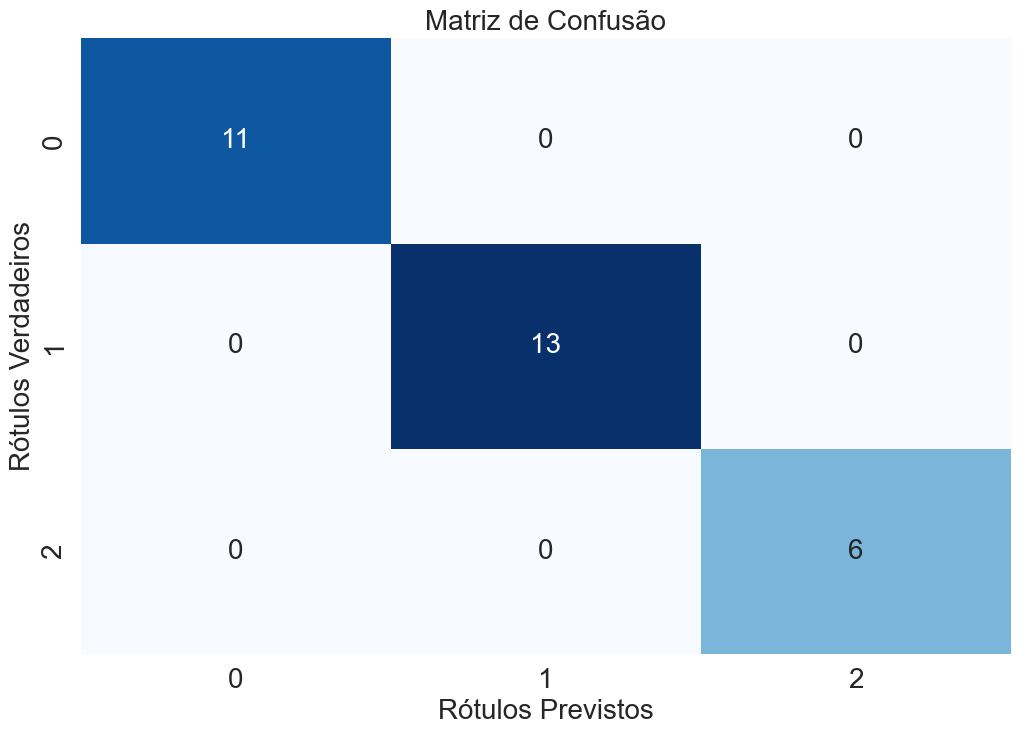

In [18]:
confusion_matrix_result = df_results_nc.loc[index_selected, "confusion_matrix"]


plt.figure(figsize=FIG_SIZE)
sns.heatmap(
    confusion_matrix_result,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    annot_kws={"size": 20},
)
plt.xlabel("Rótulos Previstos", fontsize=20)
plt.ylabel("Rótulos Verdadeiros", fontsize=20)
plt.title("Matriz de Confusão", fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Calculo de superfície de decisão para NR

In [19]:
feature_x = X_train.columns[0]
feature_y = X_train.columns[1]

feature_x_max = X_train[feature_x].max()
feature_x_min = X_train[feature_x].min()

feature_y_max = X_train[feature_y].max()
feature_y_min = X_train[feature_y].min()

print(f"Feature {feature_x} - Máximo: {feature_x_max}, Mínimo: {feature_x_min}")

print(f"Feature {feature_y} - Máximo: {feature_y_max}, Mínimo: {feature_y_min}")

h = 0.05

xx, yy = np.meshgrid(
    np.arange(feature_x_min, feature_x_max + h, h),
    np.arange(feature_y_min, feature_y_max + h, h),
)

test_grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[feature_x, feature_y])

Z = nearest_centroid_predict(X_train, y_train, test_grid)

Z = Z.reshape(xx.shape)

Feature sepal length - Máximo: 7.9, Mínimo: 4.3
Feature sepal width - Máximo: 4.4, Mínimo: 2.0


# Plot da superfície de decisão para o NC

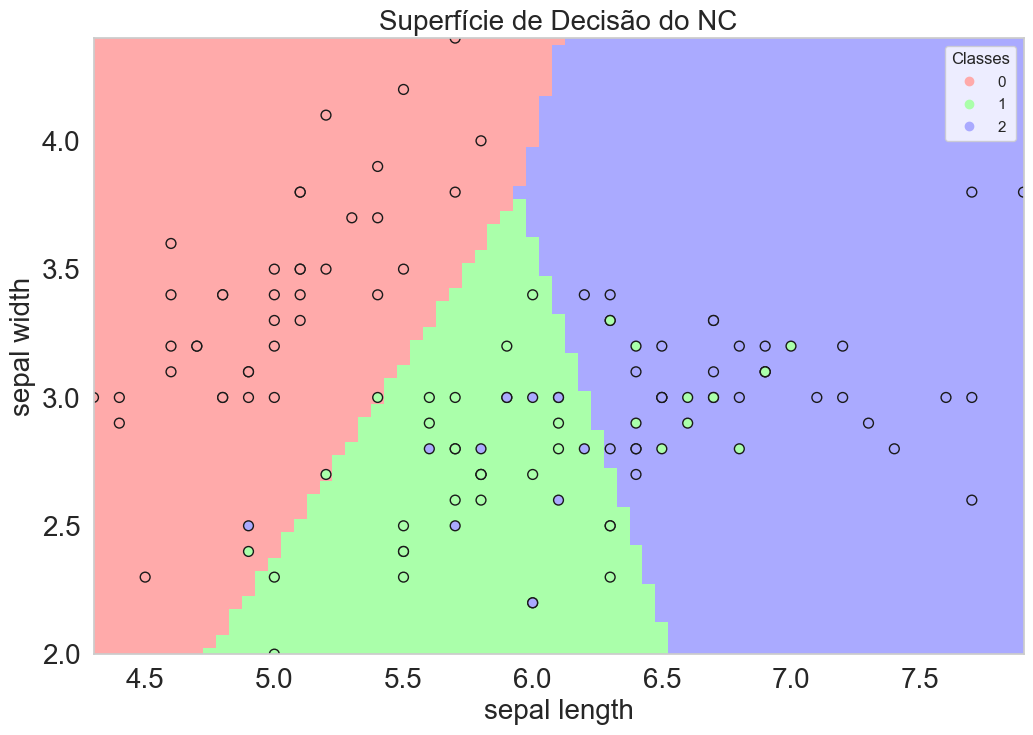

In [20]:
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])

plt.figure(figsize=FIG_SIZE)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
sc = plt.scatter(
    X_train[feature_x],
    X_train[feature_y],
    c=y_train,
    edgecolor="k",
    s=50,
    cmap=cmap_light,
)
plt.legend(*sc.legend_elements(), title="Classes", loc="upper right")

plt.xlabel(feature_x, fontsize=20)
plt.ylabel(feature_y, fontsize=20)
plt.title("Superfície de Decisão do NC", fontsize=20)

plt.xlim(feature_x_min, feature_x_max)
plt.ylim(feature_y_min, feature_y_max)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()